In [1]:
import numpy as np 
import math

#---------------------------------------------------PARAMS----------------------------------------------------------
ROTATION_ANGLE = 360
ROT_MAT = np.zeros((360,2,2))
#decision_makers = [eps_greedy, softmax, selective_attention]
labels = ["Epsilon Greedy", "Softmax", "Selective Attention"]
for i in range(360):
    d = float(i/180)*math.pi
    ROT_MAT[i] = np.array([[math.cos(d),  -math.sin(d)],
                         [math.sin(d), math.cos(d)]])

p = 0.02
W = int(1/p)+1
tau = np.hstack([np.arange(0.0, 2.0, 0.01),np.arange(2.0, 10.0, 0.01),np.arange(10,100,2), np.arange(100,500,5)])
N_tau = np.size(tau)
epsilon = np.arange(W)*p
epsilon = np.around(epsilon, decimals = 3)
N_eps = np.size(epsilon)

def softmax(R,T):
    P = np.zeros((W,N_tau,4))
    for n in range(N_tau):
        for w in range(W):
            weight = [w*p, 1.0-w*p]
            #print(weight[0], R, weight[1], T)
            temp = np.dot(weight, [R,T])*tau[n]
            temp = temp - np.max(temp)
            P[w,n,:] = np.exp(temp)/np.sum(np.exp(temp))
    learner = "Softmax One"
    return P, learner

def selective_attention(R,T):
    P = np.zeros((W,N_tau,4))
    for n in range(N_tau):
        ex_R = np.exp((R - np.max(R))*tau[n])
        ex_T = np.exp((T - np.max(T))*tau[n])
        weight_R = ex_R/np.sum(ex_R)
        weight_T = ex_T/np.sum(ex_T)
        for w in range(W):
            weight = [w*p,1.0-w*p]
            P[w,n,:] = weight[0]*weight_R + weight[1]*weight_T
    learner = "Softmax Two"
    return np.round(P,3), learner

def eps_greedy(R,T):
    P = np.zeros((W,N_eps,4))
    temp = np.zeros(4)
    for n in range(N_eps):
        for w in range(W):
            weight = [w*p, 1-w*p]
            for i in range(4):
                temp[i] = weight[0]*R[i] + weight[1]*T[i]
            k = np.argmax(temp)
            for i in range(4):
                if i == k:
                    P[w,n,i] = 1-0.75*epsilon[n]
                else:
                    P[w,n,i] = 0.25*epsilon[n]
    
    learner = "Epsilon-Greedy"
    return P, learner
# below runs everything in reward-threat space        
def run(decision_maker, R,T, WEIGHT, TAU):
    prob, learner_type = decision_maker(R,T)
    reward = np.dot(prob[WEIGHT,TAU], R)
    threat = np.dot(prob[WEIGHT,TAU], T)        
    return reward, threat

def run_all(decision_maker, R,T):
    if decision_maker!=eps_greedy:
        reward = np.zeros((W,N_tau))
        threat = np.zeros((W,N_tau))
        prob, learner_type = decision_maker(R,T)
        for w in range(W):
            for n in range(N_tau):
                reward[w,n] = np.dot(prob[w,n], R)
                threat[w,n] = np.dot(prob[w,n], T)
    else:
        reward = np.zeros((W,N_eps))
        threat = np.zeros((W,N_eps))
        prob, learner_type = decision_maker(R,T)
        for w in range(W):
            for n in range(N_eps):
                reward[w,n] = np.dot(prob[w,n], R)
                threat[w,n] = np.dot(prob[w,n], T)        
    return reward, threat



# helper rotator function here
# rotate point by angle based on center
def rotate(x, y, i):
    L = len(x)
    p = np.array([x,y])
    #print(p)
    xx = np.mean(x)
    yy = np.mean(y)
    m = np.zeros((2,L))
    for l in range(L):
        m[0,l] = xx
        m[1,l] = yy
    #print(m)
    rotated = np.dot(ROT_MAT[i], np.array([x,y]) - m) + m
    return np.array(rotated)
# given 4 points in reward-threat space, counts how many of them are on the Pareto boundary
def pareto_counter(x,y):
    count = 0
    for i in range(4):
        count_i = 0
        for j in range(4):
            if x[j]>x[i] and y[j]>y[i]:
                count_i+=1

        if count_i == 0:

            count+=1
    return count

def perturb(T,R, i, r):
    # T,R are the rewards and i is index being perturbed with radius r
    T_p = np.zeros((360,4))
    R_p = np.zeros((360,4))
    
    # ref is the starting point of the rotation
    ref = np.array([T[i], R[i]+r])
    center = np.array([T[i], R[i]])
    for j in range(360):
        T_p[j,:] = T
        R_p[j,:] = R
        temp = np.dot(ROT_MAT[j], ref - center) + center
        T_p[j,i] = temp[0]
        R_p[j,i] = temp[1]
    return T_p, R_p


In [2]:
# implementing fsolve directly with 2 variables
# this cell is only for SA given eps greedy
import math
import scipy.optimize
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

rad = 0.3 # radiu of the perturbation
WEIGHT = 35
EPSILON = 20
R0 = np.array([0,4,9,10])
T0 = np.array([0,-1,-4,-10])
T1,R1 = rotate(T0,R0,180)
def weighting(t, arr):
    temp = arr*t
    temp = temp - np.max(temp)
    temp = np.exp(temp)/(np.sum(np.exp(temp)))
    return temp

def f_SA(variables, *data) :
    x,y = data
    (w,tau) = variables
    w_p = weighting(tau, R)
    w_m = weighting(tau, T)
    weighted_sum = w*w_p + (1-w)*w_m
    
    first_eq = np.dot(weighted_sum, R) - y
    second_eq = np.dot(weighted_sum, T) - x
    return [first_eq, second_eq]

T,R = rotate(T1,R1,200)
T_p, R_p = perturb(T,R,3,rad)
eps_reward, eps_threat = run_all(eps_greedy,R_p[180,:],T_p[180,:])

y0 = eps_reward[WEIGHT, EPSILON]
x0 = eps_threat[WEIGHT, EPSILON]
sa_solution = scipy.optimize.fsolve(f_SA, (0.7, 2),(x0,y0)) # this gives (w,tau) for which SA gives given eps_greedy point shown in green
eps_reward, eps_threat = run_all(selective_attention,R,T)
#plt.scatter(eps_threat, eps_reward, color = 'orange')

# single given value solver for SA
def sa_solver(R, T, w, tau):
    temp = R*tau
    temp = temp - np.max(temp)
    R_plus = np.exp(temp)/np.sum(np.exp(temp))
    temp = T*tau
    temp = temp - np.max(temp)
    T_plus = np.exp(temp)/np.sum(np.exp(temp))
    temp = w*R_plus +(1-w)*T_plus
    y_value = np.dot(temp, R)
    x_value = np.dot(temp, T)
    return x_value, y_value
print(sa_solver(R,T,sa_solution[0], sa_solution[1]), " this is checking if the above SA solver is working correctly. Should give same values")

# single given value solver for SM
def sm_solver(R, T, w, tau):
    temp = (w*R + (1-w)*T)*tau
    temp = temp - np.max(temp)
    probs = np.exp(temp)/np.sum(np.exp(temp))
    y_value = np.dot(probs, R)
    x_value = np.dot(probs, T)
    return x_value, y_value
# single given value solver of eps_greedy
def eps_solver(R,T, w, eps_n):
    k = np.argmax(w*R + (1-w)*T)
    probs = np.zeros(4)
    for i in range(4):
        if i==k:
            probs[i] = 1-0.75*epsilon[eps_n]
        else:
            probs[i] = 0.25*epsilon[eps_n]
    y_value = np.dot(probs, R)
    x_value = np.dot(probs, T)
    return x_value, y_value

yy,xx = run_all(softmax, R, T)

# now write a solver for Softmax here given values x,y
def f_SM(variables, *data) :
    x,y = data
    (w,tau) = variables
    temp = (w*R + (1-w)*T)*tau
    temp = temp - np.max(temp)
    probs = np.exp(temp)/np.sum(np.exp(temp))
    first_eq = np.dot(probs, R) - y
    second_eq = np.dot(probs, T) - x
    return [first_eq, second_eq]
sm_solution = scipy.optimize.fsolve(f_SM, (0.0,5), (x0,y0))




(-4.557893172608791, 7.501097589031867)  this is checking if the above SA solver is working correctly. Should give same values


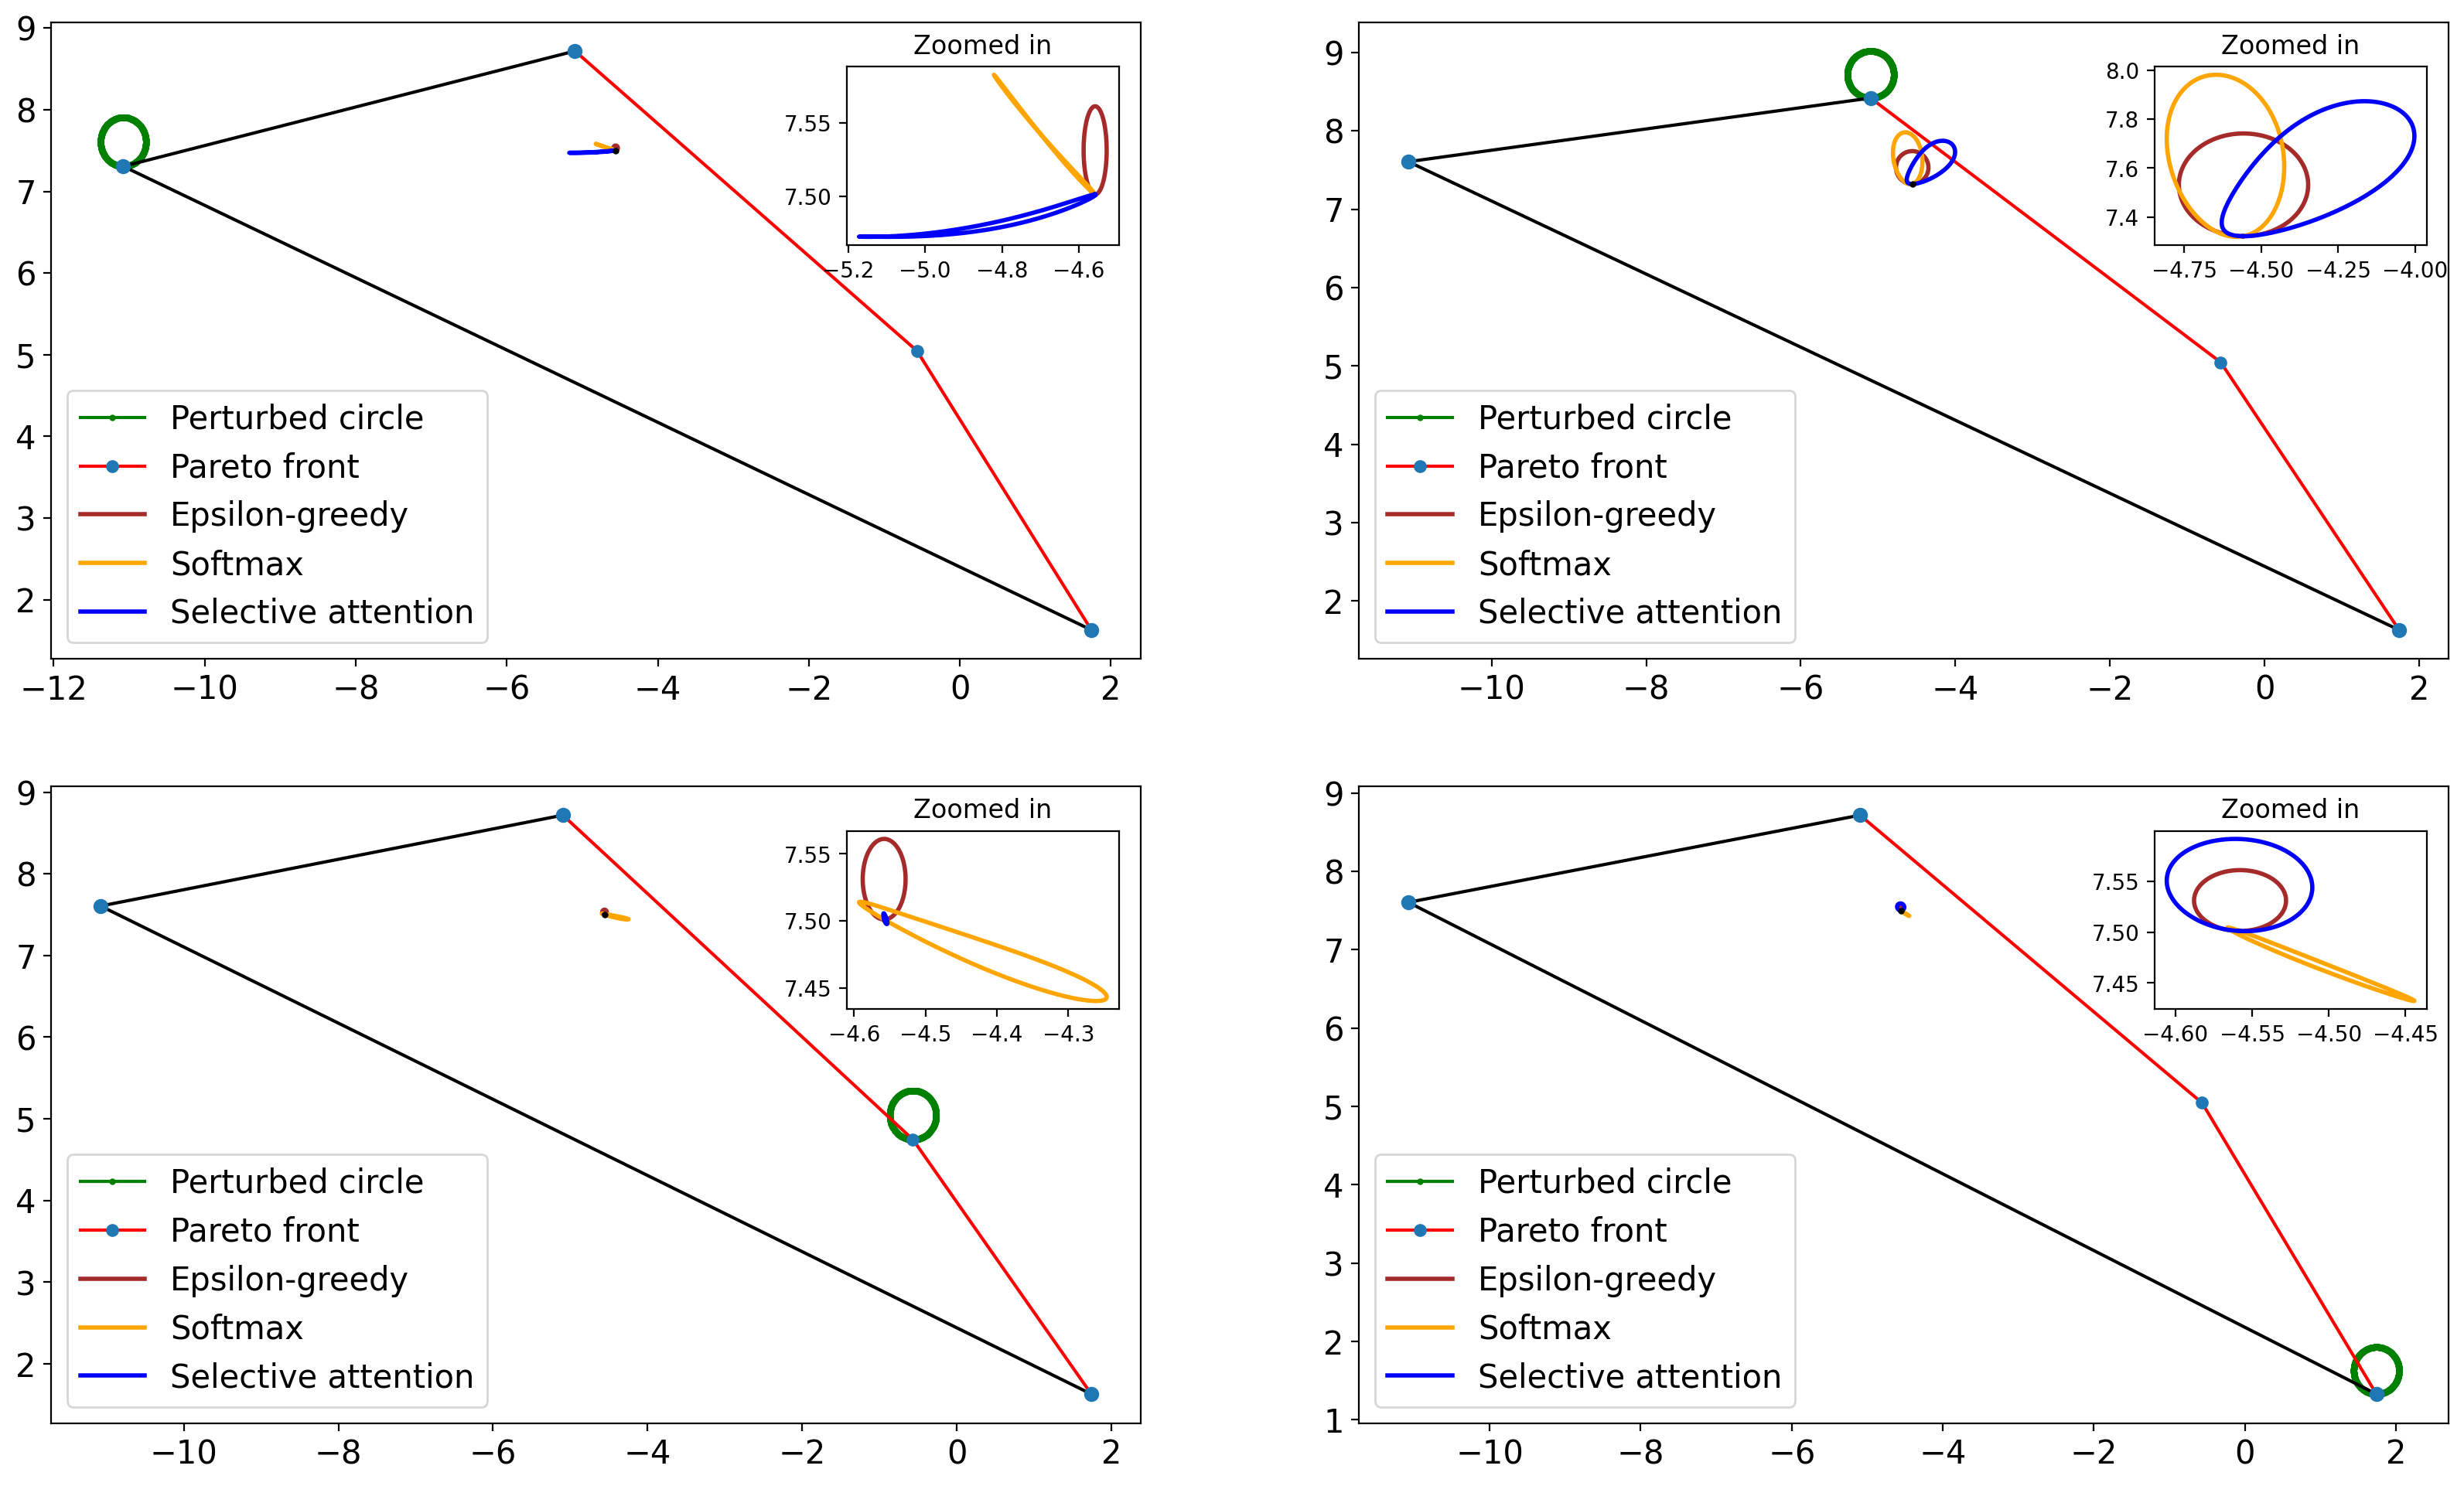

In [3]:
R0 = np.array([0,4,9,10])
T0 = np.array([0,-1,-4,-10])
T,R = rotate(T0,R0,20)
ROTATION_ANGLE = 360
colors = ['brown', 'orange', 'blue']
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (20,12), dpi = 200)
axs = [ax1, ax2, ax3, ax4]

font = {'family': 'serif',
        'color':  'blue',
        'weight': 'normal',
        'size': 25,
        }

for s in range(4):
    T_p, R_p = perturb(T,R,3-s,rad)
    R[3-s]-=rad
    eps_reward, eps_threat = run_all(eps_greedy,R_p[180,:],T_p[180,:])
    y0 = eps_reward[WEIGHT, EPSILON]
    x0 = eps_threat[WEIGHT, EPSILON]
    # 0 is eps, 1 is softmax, 2 is selective-attention
    sa_solution = scipy.optimize.fsolve(f_SA, (0.7, 2),(x0,y0)) # this gives (w,tau) for which SA gives given eps_greedy point 
    sm_solution = scipy.optimize.fsolve(f_SM, (0.7, 2), (x0,y0))
    y = np.zeros((3,360))
    x = np.zeros((3,360))
    for i in range(ROTATION_ANGLE):
        j = (i+180)%360
        x[0,i], y[0,i] = eps_solver(R_p[j,:], T_p[j,:], WEIGHT*p, EPSILON)
        x[1,i], y[1,i] = sm_solver(R_p[j,:], T_p[j,:], sm_solution[0], sm_solution[1])
        x[2,i], y[2,i] = sa_solver(R_p[j,:], T_p[j,:], sa_solution[0], sa_solution[1])
    axs[s].plot(T_p[:,3-s], R_p[:,3-s],'-o', color = 'green', markersize = 2)
    axs[s].plot(T[0:3],R[0:3],"-o", c= 'red', markersize = 5, mec ='#1f77b4', mfc = '#1f77b4' )
    axs[s].plot([T[2], T[3], T[0]],[R[2], R[3], R[0]],"-o", c= 'black', mec ='#1f77b4', mfc = '#1f77b4',label = '_nolegend_' )
   
    for i in range(3):
        axs[s].plot(x[i,0:ROTATION_ANGLE], y[i,0:ROTATION_ANGLE], color = colors[i], linewidth = 2)

    # location for the zoomed portion 
    sub_axes = axs[s].inset_axes([.73, .65, .25, .28]) 

    # plot the zoomed portion
    for i in range(3):
        sub_axes.plot(x[i,0:ROTATION_ANGLE], y[i,0:ROTATION_ANGLE], color = colors[i], linewidth = 2) 
    axs[s].plot(x0,y0,'-o',color = 'black', markersize = 2)
    axs[s].tick_params(axis="x", labelsize=15)
    axs[s].tick_params(axis="y", labelsize=15)
    axs[s].legend(['Perturbed circle','Pareto front','Epsilon-greedy', 'Softmax', 'Selective attention'], fontsize = 15)
    sub_axes.set_title('Zoomed in', color = 'black')
    R[3-s]+=rad
